In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.src.layers import Embedding, SimpleRNN, Dense, Flatten
from keras import Sequential

In [46]:
df = pd.read_csv('data.csv', sep=';')
series_analise =  df['Максимальная  температура'] 
series_analise_date = df['Дата']


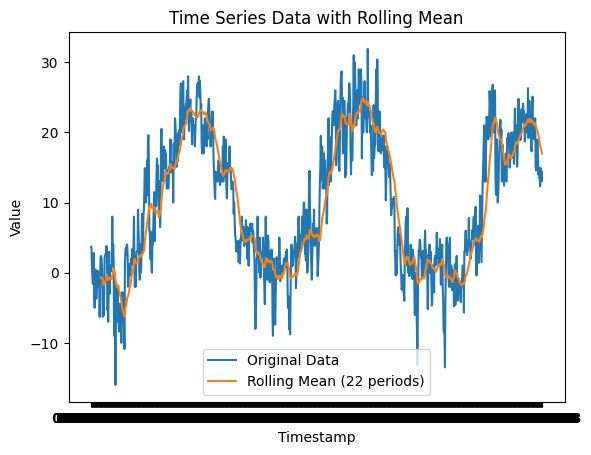

In [47]:

window_size = 22  # количество прошлых периодов
rolling_mean = series_analise.rolling(window=window_size).mean()

plt.plot(series_analise_date, series_analise, label='Original Data')
plt.plot(series_analise_date, rolling_mean, label=f'Rolling Mean ({window_size} periods)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Time Series Data with Rolling Mean')
plt.legend()
plt.show()


In [48]:
from sklearn.model_selection import train_test_split
import numpy as np 

feature = pd.to_datetime(series_analise_date, format='%d.%m.%Y').astype(int) // 10**9 # переводим в секунды

X_train, X_test, y_train, y_test = train_test_split(np.array(feature).reshape(-1, 1), series_analise, test_size=0.2, random_state=42)


In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = LinearRegression()  

model.fit(X_train, y_train)
predictions = model.predict(X_test)

print('MAE:', mean_absolute_error(y_test, predictions))
print('MSE:', mean_squared_error(y_test, predictions))
print('R^2:', r2_score(y_test, predictions))



MAE: 8.876456840334942
MSE: 102.27280524189395
R^2: 0.028116460166498825


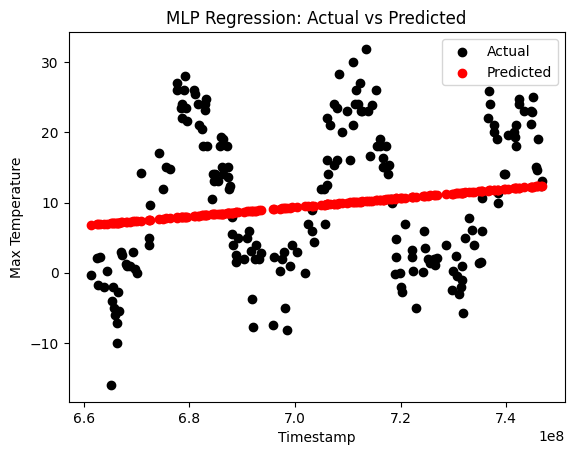

In [50]:
plt.scatter(X_test, y_test, color='black', label='Actual')
plt.scatter(X_test, predictions, color='red', label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Max Temperature')
plt.title('MLP Regression: Actual vs Predicted')
plt.legend()
plt.show()

In [51]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()  

model.fit(X_train, y_train)
predictions = model.predict(X_test)

print('MAE:', mean_absolute_error(y_test, predictions))
print('MSE:', mean_squared_error(y_test, predictions))
print('R^2:', r2_score(y_test, predictions))




MAE: 2.1910049999999988
MSE: 8.235415194999998
R^2: 0.9217400514947782


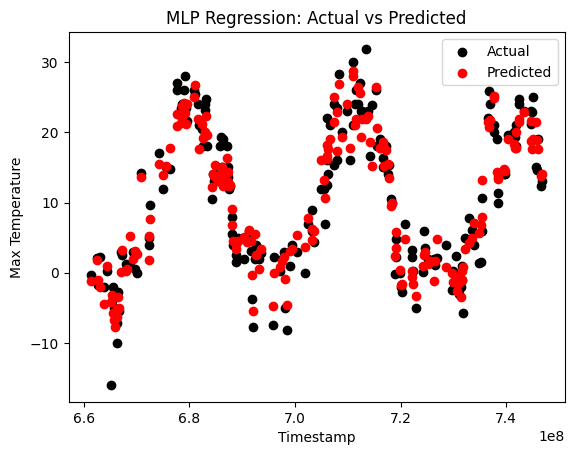

In [52]:
plt.scatter(X_test, y_test, color='black', label='Actual')
plt.scatter(X_test, predictions, color='red', label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Max Temperature')
plt.title('MLP Regression: Actual vs Predicted')
plt.legend()
plt.show()

In [53]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(22, 10), max_iter=100, random_state=42)
model.fit(X_train, y_train)

# Прогнозирование на тестовом наборе
predictions = model.predict(X_test)

print('MAE:', mean_absolute_error(y_test, predictions))
print('MSE:', mean_squared_error(y_test, predictions))
print('R^2:', r2_score(y_test, predictions))


MAE: 9.03855136771133
MSE: 104.54855754256964
R^2: 0.006490318236259562


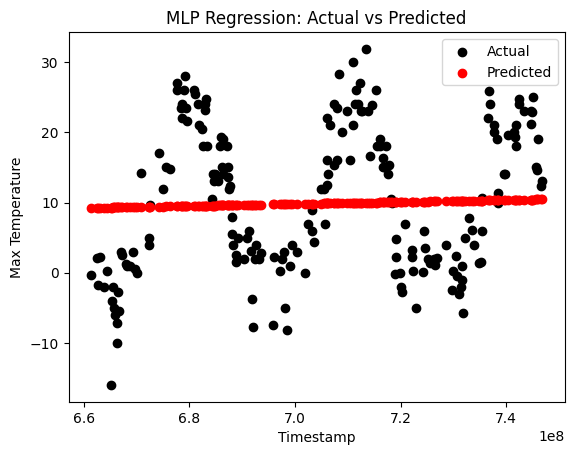

In [54]:
plt.scatter(X_test, y_test, color='black', label='Actual')
plt.scatter(X_test, predictions, color='red', label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Max Temperature')
plt.title('MLP Regression: Actual vs Predicted')
plt.legend()
plt.show()

In [69]:
from sklearn.preprocessing import MinMaxScaler
from keras.src.optimizers import RMSprop
from keras.src.layers import GRU

# если 10 слов -> на каждый рекурентный узел будет по 10 нейронов
# 32 рекурентных узла не нейронов 
X = feature.values.reshape(-1, 1)
y = series_analise.values.reshape(-1, 1)

# Масштабируем признаки
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Функция для преобразования данных в формат, подходящий для LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Определение параметров модели
time_steps = 22
n_features = 1  # количество признаков

# Создание обучающего и тестового набора данных в формате LSTM
X_train_lstm, y_train_lstm = create_dataset(X_train, y_train, time_steps)
X_test_lstm, y_test_lstm = create_dataset(X_test, y_test, time_steps)

# Создание и обучение модели LSTM с использованием Keras
model = Sequential()
# model.add(Embedding(n_features, 32))
model.add(GRU(units=50, activation='relu', input_shape=(time_steps, n_features)))
model.add(Flatten())
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_lstm, y_train_lstm, epochs=50, verbose=1)

# Прогнозирование на тестовом наборе
predictions_scaled = model.predict(X_test_lstm)

# Инверсия масштабирования для получения исходных значений
predictions = scaler_y.inverse_transform(predictions_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_lstm)

print('MAE:', mean_absolute_error(y_test_inv, predictions))
print('MSE:', mean_squared_error(y_test_inv, predictions))
print('R^2:', r2_score(y_test_inv, predictions))


Epoch 1/50
25/25 [==============================] - 1s 4ms/step - loss: 0.0399
Epoch 2/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0395
Epoch 3/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0396
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0394
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0395
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0394
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0394
Epoch 8/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0394
Epoch 9/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0395
Epoch 10/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0394
Epoch 11/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0395
Epoch 12/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0394
Epoch 13/50
25/25 [==============================

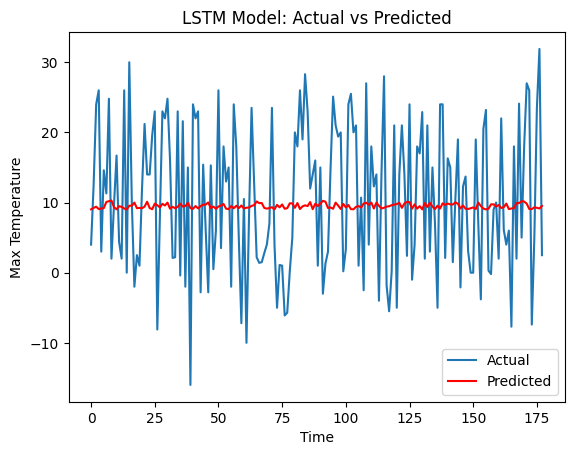

In [70]:


plt.plot(y_test_inv, label='Actual')
plt.plot(predictions, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Max Temperature')
plt.title('LSTM Model: Actual vs Predicted')
plt.legend()
plt.show()

